In [1]:
import os, time, h5py, platform, json, sys, matplotlib, glob
if platform.system() == 'Linux':
    import matplotlib
    matplotlib.use('Agg')
sys.path.append("/Users/gkoolstra/Documents/Code")
sys.path.append(r"C:\Users\Gerwin\Documents\Code")
from matplotlib import pyplot as plt
from shutil import copyfile
import numpy as np
from tqdm import tqdm, trange
from scipy.optimize import minimize
from scipy.signal import savgol_filter
from termcolor import cprint
from glob import glob
from Common import common, kfit
import matplotlib.gridspec as gridspec
from TrapAnalysis import trap_analysis, artificial_anneal as anneal
%matplotlib inline
%config InlineBackend.figure_format='retina'

try:
    sys.path.append(r"S:\_Data\170422 - EonHe M018V6 with L3 etch\experiment")
    from data_cache import dataCacheProxy
except:
    pass

**Relevant references**
* Experiment: https://journals.aps.org/prb/pdf/10.1103/PhysRevB.79.045406
* Numerics: https://journals.aps.org/pre/abstract/10.1103/PhysRevE.65.046602

In [2]:
from TrapAnalysis.solve_eom import FullSolver
from scipy.constants import elementary_charge as q_e, electron_mass as m_e

settings_file = r"/Users/gkoolstra/Desktop"
settings_file += r"/With L3 etch - just trap/settings.json"
fs = FullSolver(settings_file)

# Set up the RF electric field path and load it into memory
fs.resonator_constants['f0'] = 6.405E9
fs.resonator_constants['Q'] = 1.3E4
fs.resonator_constants['Z0'] = 90.0

def Ex(xi, yi):
    return 1e1 * np.ones(len(xi))

def Ey(xi, yi):
    return 3E5 * np.exp(-yi ** 2 / (2 * (0.5E-6) ** 2))

fs.Ex = Ex
fs.Ey = Ey

kappa_tot = fs.resonator_constants['f0'] / fs.resonator_constants['Q']

In [3]:
fs.include_screening

1

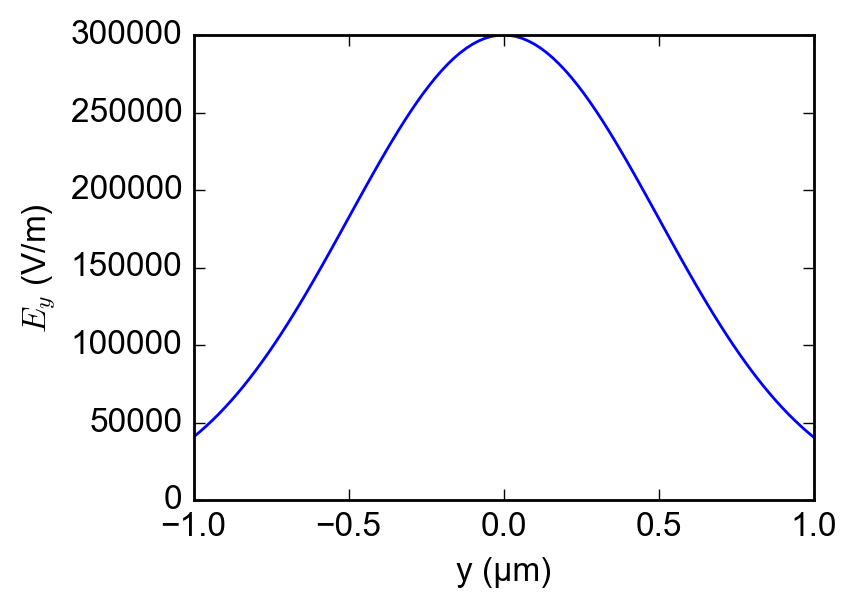

In [4]:
yplot = np.linspace(-1E-6, 1E-6, 101)

plt.figure(figsize=(4.,3.))
common.configure_axes(12)
plt.plot(yplot * 1E6, Ey(np.zeros(len(yplot)), yplot))
plt.xlabel("y (%sm)"%chr(956))
plt.ylabel("$E_y$ (V/m)")

In [10]:
initial_guesses = [{"N" : 1, "init_guess" : np.array([0, 0]), 
                    "adaptive_guess" : True}, 
                   {"N" : 2, "init_guess" : np.array([0.0, 3.34106244e-07, 0.0, -3.34106244e-07]), 
                    "adaptive_guess" : True},
                   {"N" : 3, "init_guess" : np.array([1.88584116e-07, 4.83470160e-07, -2.48886397e-07, 
                                                      -4.83471271e-07, 1.75130320e-07, 7.89948645e-07]), 
                    "adaptive_guess" : True}, 
                   {"N" : 4, "init_guess" : np.array([2.40087325e-07, -7.35031356e-12, -2.40087325e-07, 
                                                      -7.35031356e-12, 0, 5.20539644e-07, 0, -5.20536454e-07]), 
                    "adaptive_guess" : True}, 
                   {"N" : 5, "init_guess" : np.array([2.40087325e-07, -7.35031356e-12, -2.40087325e-07, 
                                                      -7.35031356e-12, 0, 5.20539644e-07, 0, -5.20536454e-07, 
                                                      0, 0]), 
                    "adaptive_guess" : True}
                  ]

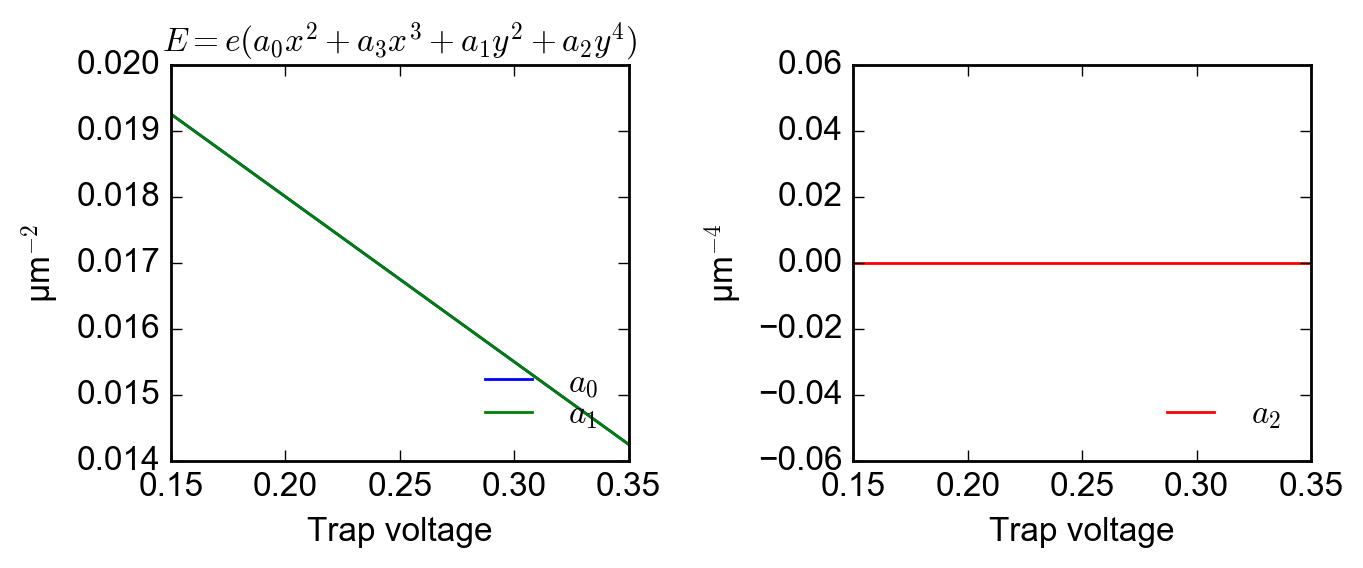

In [5]:
dfdV = 90E9
V_crossing = 0.174

V0 = V_crossing - fs.resonator_constants['f0'] / (2 * dfdV)

Vtrap = np.linspace(0.15, 0.35, 2)
Vrg = np.linspace(-0.415, -0.426, len(Vtrap))
Vres = 0.60 * np.ones(len(Vtrap)) 
Vtg = 0.00 * np.ones(len(Vtrap))

a_0s = 1E12 * (0.023 - 0.025 * Vtrap) #1E12 * (0.032 - 0.006 - 0.020 * Vtrap)
a_1s = a_0s #1E12 * (-0.0214 + 0.149 * Vtrap)

a_2s = 0*1E24 * (0.016 - 0.01 * Vtrap)
a_3s = 0*0.8 * -1E16 * np.ones(len(Vtrap))

contain_xs = 0*0.001E24 * np.ones(len(Vtrap))

fig = plt.figure(figsize=(7.,3.))
common.configure_axes(12)
plt.subplot(121)
plt.title("$E = e (a_0 x^2 + a_3 x^3 + a_1 y^2 + a_2 y^4)$", size=12)
plt.plot(Vtrap, a_0s * 1E-12, label="$a_0$")
plt.plot(Vtrap, a_1s * 1E-12, label='$a_1$')
plt.xlim(np.min(Vtrap), np.max(Vtrap))
plt.xlabel("Trap voltage")
plt.ylabel("%sm$^{-2}$"%(chr(956)))
plt.legend(loc=4, prop={"size" : 12}, frameon=False)

plt.subplot(122)
plt.plot(Vtrap, a_2s * 1E-24, label='$a_2$', color='r')
# plt.plot(Vtrap, a_3s * 1E-24, label='$a_3$', color='c')
plt.xlim(np.min(Vtrap), np.max(Vtrap))
plt.xlabel("Trap voltage")
plt.ylabel("%sm$^{-4}$"%(chr(956)))
plt.legend(loc=4, prop={"size" : 12}, frameon=False)

fig.tight_layout()

2it [00:00, 11.85it/s]
2it [00:00, 11.73it/s]
2it [00:00, 10.62it/s]
0it [00:00, ?it/s]/Users/gkoolstra/Documents/Code/TrapAnalysis/solve_eom.py:266: RuntimeWarning: divide by zero encountered in true_divide
  tij = np.arctan(YiYj / XiXj)
2it [00:00,  9.63it/s]


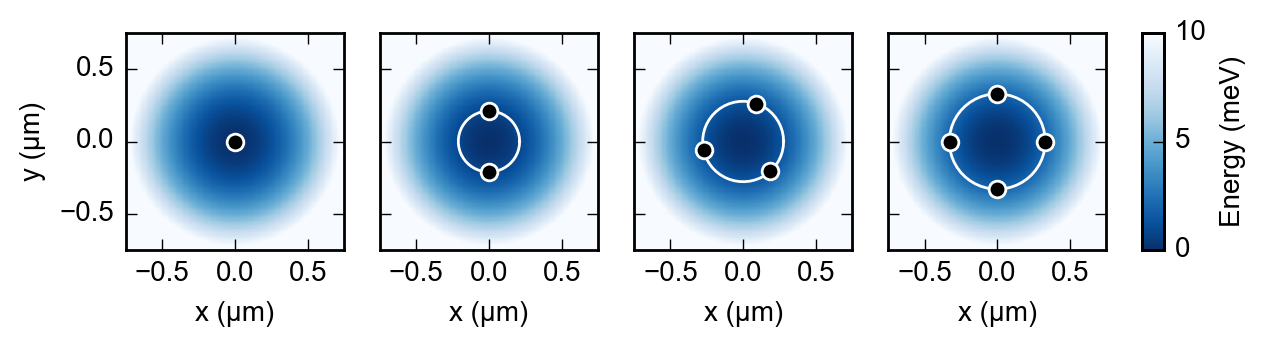

In [48]:
import matplotlib.gridspec as gridspec

fs.trap_annealing_steps = [0.5] * 10
solve_equations_of_motion = 1
num_columns = 4

fig2 = plt.figure(figsize=(6.7, 1.4))
common.configure_axes(10)

gs = gridspec.GridSpec(1, 5, width_ratios=[1, 1, 1, 1, 0.1], hspace=0.5)

ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
cbar_ax = plt.subplot(gs[0, 4])

colors = [plt.cm.viridis(frac) for frac in [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]]

from TrapAnalysis import single_electron as se

for N in [1, 2, 3, 4]:
    color = colors[::-1][5 - N]
    use_adaptive_initial_guess = initial_guesses[N-1]["adaptive_guess"]
    electron_initial_positions = initial_guesses[N-1]["init_guess"]

    electrons_in_the_trap = list()
    electron_positions = list(); energies = list()
    EVecs = list(); EVals = list()

    Second_Derivs = np.zeros((len(Vtrap), N, 3))

    for k, potential_coeffs in tqdm(enumerate(zip(a_0s, a_1s, a_2s, a_3s, contain_xs))):
        a_0, a_1, a_2, a_3, contain_x = potential_coeffs

        def Phi(xi, yi):
            return a_0 * xi ** 2 + a_3 * xi ** 3  + contain_x * xi ** 4 + a_1 * yi ** 2 + a_2 * yi ** 4

        def Phi_x(xi, yi):
            return 2 * a_0 * xi + 3 * a_3 * xi ** 2 + 4 * contain_x * xi ** 3

        def Phi_y(xi, yi):
            return 2 * a_1 * yi + 4 * a_2 * yi ** 3

        def Phi_xx(xi, yi):
            return 2 * a_0 * np.ones(len(xi)) + 6 * a_3 * xi + 12 * contain_x * xi ** 2

        def Phi_xy(xi, yi):
            return np.zeros(len(xi))

        def Phi_yy(xi, yi):
            return 2 * a_1 * np.ones(len(xi)) + 12 * a_2 * yi ** 2

        dummy_x = np.linspace(-2E-6, 2E-6, 501)
        dummy_y = np.linspace(-2E-6, 2E-6, 501)

        CMS = anneal.TrapAreaSolver(dummy_x, dummy_y, np.meshgrid(dummy_x, dummy_y)[0],
                                    spline_order_x=3, spline_order_y=3, smoothing=0,
                                    include_screening=fs.include_screening, screening_length=fs.screening_length)
        CMS.V = Phi

        CMS.dVdx = Phi_x
        CMS.dVdy = Phi_y

        fs.curv_xx = Phi_xx
        fs.curv_xy = Phi_xy
        fs.curv_yy = Phi_yy

        X_eval, Y_eval = np.meshgrid(dummy_x, dummy_y)

        # Solve for the electron positions in the trap area!
        ConvMon = anneal.ConvergenceMonitor(Uopt=CMS.Vtotal, grad_Uopt=CMS.grad_total, N=1,
                                            Uext=CMS.V,
                                            xext=dummy_x, yext=dummy_y, verbose=False, eps=fs.epsilon,
                                            save_path=None)

        ConvMon.figsize = (8., 2.)

        trap_minimizer_options = {'method': 'L-BFGS-B',
                                  'jac': CMS.grad_total,
                                  'options': {'disp': False, 'gtol': fs.gradient_tolerance, 'eps': fs.epsilon},
                                  'callback': None}

        # We save the initial Jacobian of the system for purposes.
        initial_jacobian = CMS.grad_total(electron_initial_positions)
        res = minimize(CMS.Vtotal, electron_initial_positions, **trap_minimizer_options)

        while res['status'] > 0:
            # Try removing unbounded electrons and restart the minimization
            if fs.remove_unbound_electrons:
                # Remove any electrons that are to the left of the trap
                best_x, best_y = anneal.r2xy(res['x'])
                idxs = np.where(np.logical_and(best_x > fs.remove_bounds[0], best_x < fs.remove_bounds[1]))[0]
                best_x = np.delete(best_x, idxs)
                best_y = np.delete(best_y, idxs)
                # Use the solution from the current time step as the initial condition for the next timestep!
                electron_initial_positions = anneal.xy2r(best_x, best_y)
                if len(best_x) < len(res['x'][::2]):
                    print("%d/%d unbounded electrons removed. %d electrons remain." % (
                    np.int(len(res['x'][::2]) - len(best_x)), len(res['x'][::2]), len(best_x)))
                res = minimize(CMS.Vtotal, electron_initial_positions, **trap_minimizer_options)
            else:
                best_x, best_y = anneal.r2xy(res['x'])
                idxs = np.union1d(np.where(best_x < -2E-6)[0], np.where(np.abs(best_y) > 2E-6)[0])
                if len(idxs) > 0:
                    print("Following electrons are outside the simulation domain")
                    for i in idxs:
                        print("(x,y) = (%.3f, %.3f) um" % (best_x[i] * 1E6, best_y[i] * 1E6))
                # To skip the infinite while loop.
                break

        if res['status'] > 0:
            cprint("WARNING: Initial minimization for Trap did not converge!", "red")
            print("Final L-inf norm of gradient = %.2f eV/m" % (np.amax(res['jac'])))
            best_res = res
            if k == 0:
                cprint("Please check your initial condition, are all electrons confined in the simulation area?", "red")
                break

        if len(fs.trap_annealing_steps) > 0:
            # cprint("SUCCESS: Initial minimization for Trap converged!", "green")
            best_res = CMS.perturb_and_solve(CMS.Vtotal, len(fs.trap_annealing_steps), fs.trap_annealing_steps[0],
                                             res, maximum_dx=fs.max_x_displacement, maximum_dy=fs.max_y_displacement,
                                             do_print=False, **trap_minimizer_options)
        else:
            best_res = res

        # Use the solution from the current time step as the initial condition for the next timestep!
        if use_adaptive_initial_guess:
            electron_initial_positions = best_res['x']
        ex, ey = anneal.r2xy(best_res['x'])
        electrons_in_the_trap.append(np.sum(np.logical_and(ex < 1.5E-6,
                                                           ex > 1.5E-6)))

        electron_positions.append(res['x'])
        energies.append(res['fun']) # this will contain the total minimized energy in eV

        if solve_equations_of_motion:
            LHS, RHS = fs.setup_eom(best_res['x'])
            evals, evecs = fs.solve_eom(LHS, RHS)
            EVals.append(evals)
            EVecs.append(evecs)

            Second_Derivs[k, :, 0] = fs.curv_xx(ex, ey)
            Second_Derivs[k, :, 1] = fs.curv_xy(ex, ey)
            Second_Derivs[k, :, 2] = fs.curv_yy(ex, ey)
 
    electron_positions = np.array(electron_positions)
    energies = np.array(energies)
    EVecs = np.array(EVecs)
    EVals = np.array(EVals)
    Efreqs = np.sqrt(EVals) / (2 * np.pi)

    # Plot the resonator and trap electron configuration at the voltage given by idx
    idx = common.find_nearest(Vtrap, V_crossing)
    trap_electrons_x, trap_electrons_y = anneal.r2xy(electron_positions[idx, :])
    
    a_0, a_1, a_2, a_3, contain_x = a_0s[idx], a_1s[idx], a_2s[idx], a_3s[idx], contain_xs[idx]
    def Phi(xi, yi):
        return a_0 * xi ** 2 + a_3 * xi ** 3  + contain_x * xi ** 4 + a_1 * yi ** 2 + a_2 * yi ** 4
    
#     plt.subplot(1, num_columns, N)
#     common.configure_axes(13)
    pcm = vars()['ax%d'%N].pcolormesh(dummy_x * 1E6, dummy_y * 1E6, Phi(X_eval, Y_eval) * 1E3, 
                                      cmap=plt.cm.Blues_r, vmin=0, vmax= 10, rasterized=True)#1E3 * Phi(1.0E-6, 1.0E-6))
    
    # If a_0 == a_1 (radially symmetric) and a_2 = 0, electrons should be on this ring
    theta = np.linspace(0, 2 * np.pi)
    r0 = (2 * q_e ** 2 / (m_e * 4 * np.pi * 8.85E-12 * 2 * q_e * a_1 / m_e)) ** (1 / 3.)
    
    if N == 2: 
        vars()['ax%d'%N].plot(0.5 * r0 * np.cos(theta) * 1E6, 0.5 * r0 * np.sin(theta) * 1E6, color='white')
    if N == 3: 
        vars()['ax%d'%N].plot(0.66 * r0 * np.cos(theta) * 1E6, 0.66 * r0 * np.sin(theta) * 1E6, color='white')
    if N == 4: 
        vars()['ax%d'%N].plot(0.782 * r0 * np.cos(theta) * 1E6, 0.782 * r0 * np.sin(theta) * 1E6, color='white')

    if best_res['status'] > 0:
        vars()['ax%d'%N].text(0, -2, "Minimization did not converge", fontdict={"size": 10})

    vars()['ax%d'%N].set_xlabel("x (%sm)"%(chr(956)))
    vars()['ax%d'%N].set_xlim(-0.75, 0.75)
    vars()['ax%d'%N].set_ylim(-0.75, 0.75)

    vars()['ax%d'%N].plot(trap_electrons_x * 1E6, trap_electrons_y * 1E6, 'o', color='k', 
                          alpha=1.0, mec='white', mew=1)
    
    cbar = plt.colorbar(pcm, ax=ax3, cax=cbar_ax, ticks=[0, 5, 10])
    cbar.ax.set_ylabel("Energy (meV)")
#     cbar.ax.set_yticks([0, 5, 10])
#     cbar.ax.set_yticklabels([0, 5, 10])
    if N == num_columns+1:
        pass
#         plt.colorbar(pcm, ax=ax3, cax=cbar_ax)
#         cbar.ax.set_ylabel("Energy (meV)")
    elif N == 1:
        ax1.set_ylabel("y (%sm)"%(chr(956)))
        ax1.set_yticks([-0.5, 0.0, 0.5])
    else:
        vars()['ax%d'%N].set_yticks([-0.5, 0.0, 0.5])
        vars()['ax%d'%N].set_yticklabels([])
    
    if N != num_columns+1:
        vars()['ax%d'%N].set_xticks([-0.5, 0.0, 0.5])
        
if 1:
    fig2.savefig(r"/Users/gkoolstra/Google Drive/grad school/schuster lab/Thesis backup/Thesis/Figures_Appendix/HarmonicTrap.pdf", 
                 bbox_inches='tight', pad_inches=0, dpi=300)

## Let's try a few more electron molecules

In [ ]:
initial_guesses = [{"N" : 1, "init_guess" : np.array([0, 0]), 
                    "adaptive_guess" : True}, 
                   {"N" : 2, "init_guess" : np.array([0.0, 3.34106244e-07, 0.0, -3.34106244e-07]), 
                    "adaptive_guess" : True},
                   {"N" : 3, "init_guess" : np.array([1.88584116e-07, 4.83470160e-07, -2.48886397e-07, 
                                                      -4.83471271e-07, 1.75130320e-07, 7.89948645e-07]), 
                    "adaptive_guess" : True}, 
                   {"N" : 4, "init_guess" : np.array([2.40087325e-07, -7.35031356e-12, -2.40087325e-07, 
                                                      -7.35031356e-12, 0, 5.20539644e-07, 0, -5.20536454e-07]), 
                    "adaptive_guess" : True}, 
                   {"N" : 5, "init_guess" : np.array([2.40087325e-07, -7.35031356e-12, -2.40087325e-07, 
                                                      -7.35031356e-12, 0, 5.20539644e-07, 0, -5.20536454e-07, 
                                                      0, 0]), 
                    "adaptive_guess" : True}, 
                   {"N" : 8, "init_guess" : np., 
                    "adaptive_guess" : True}, 
                   {"N" : 11, "init_guess" : np.array([2.40087325e-07, -7.35031356e-12, -2.40087325e-07, 
                                                      -7.35031356e-12, 0, 5.20539644e-07, 0, -5.20536454e-07, 
                                                      0, 0]), 
                    "adaptive_guess" : True}
                  ]

2it [00:00, 13.02it/s]
2it [00:00, 12.16it/s]
2it [00:00, 11.48it/s]
2it [00:00, 10.78it/s]
2it [00:00,  7.89it/s]


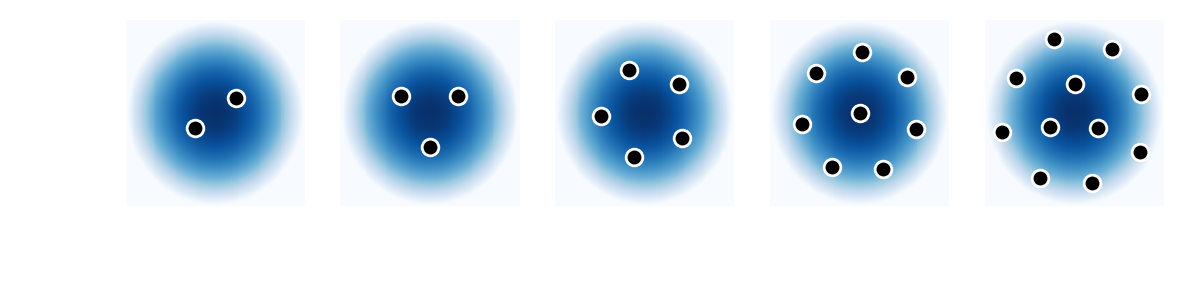

In [20]:
import matplotlib.gridspec as gridspec

fs.trap_annealing_steps = [0.5] * 10
solve_equations_of_motion = 1
num_columns = 6

fig2 = plt.figure(figsize=(6.7, 1.2))
common.configure_axes(10)

gs = gridspec.GridSpec(1, 5, width_ratios=[1, 1, 1, 1, 1], hspace=0.4)

ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])
# ax6 = plt.subplot(gs[0, 5])
# cbar_ax = plt.subplot(gs[0, 5])

colors = [plt.cm.viridis(frac) for frac in [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]]

from TrapAnalysis import single_electron as se

for it, N in enumerate([2, 3, 5, 8, 11]):
    color = colors[::-1][5 - N]
    use_adaptive_initial_guess = False #initial_guesses[N-1]["adaptive_guess"]
    electron_initial_positions = 1E-6 * np.random.rand(2 * N) #initial_guesses[N-1]["init_guess"]

    electrons_in_the_trap = list()
    electron_positions = list(); energies = list()
    EVecs = list(); EVals = list()

    Second_Derivs = np.zeros((len(Vtrap), N, 3))

    for k, potential_coeffs in tqdm(enumerate(zip(a_0s, a_1s, a_2s, a_3s, contain_xs))):
        a_0, a_1, a_2, a_3, contain_x = potential_coeffs

        def Phi(xi, yi):
            return a_0 * xi ** 2 + a_3 * xi ** 3  + contain_x * xi ** 4 + a_1 * yi ** 2 + a_2 * yi ** 4

        def Phi_x(xi, yi):
            return 2 * a_0 * xi + 3 * a_3 * xi ** 2 + 4 * contain_x * xi ** 3

        def Phi_y(xi, yi):
            return 2 * a_1 * yi + 4 * a_2 * yi ** 3

        def Phi_xx(xi, yi):
            return 2 * a_0 * np.ones(len(xi)) + 6 * a_3 * xi + 12 * contain_x * xi ** 2

        def Phi_xy(xi, yi):
            return np.zeros(len(xi))

        def Phi_yy(xi, yi):
            return 2 * a_1 * np.ones(len(xi)) + 12 * a_2 * yi ** 2

        dummy_x = np.linspace(-2E-6, 2E-6, 501)
        dummy_y = np.linspace(-2E-6, 2E-6, 501)

        CMS = anneal.TrapAreaSolver(dummy_x, dummy_y, np.meshgrid(dummy_x, dummy_y)[0],
                                    spline_order_x=3, spline_order_y=3, smoothing=0,
                                    include_screening=fs.include_screening, screening_length=fs.screening_length)
        CMS.V = Phi

        CMS.dVdx = Phi_x
        CMS.dVdy = Phi_y

        fs.curv_xx = Phi_xx
        fs.curv_xy = Phi_xy
        fs.curv_yy = Phi_yy

        X_eval, Y_eval = np.meshgrid(dummy_x, dummy_y)

        # Solve for the electron positions in the trap area!
        ConvMon = anneal.ConvergenceMonitor(Uopt=CMS.Vtotal, grad_Uopt=CMS.grad_total, N=1,
                                            Uext=CMS.V,
                                            xext=dummy_x, yext=dummy_y, verbose=False, eps=fs.epsilon,
                                            save_path=None)

        ConvMon.figsize = (8., 2.)

        trap_minimizer_options = {'method': 'L-BFGS-B',
                                  'jac': CMS.grad_total,
                                  'options': {'disp': False, 'gtol': fs.gradient_tolerance, 'eps': fs.epsilon},
                                  'callback': None}

        # We save the initial Jacobian of the system for purposes.
        initial_jacobian = CMS.grad_total(electron_initial_positions)
        res = minimize(CMS.Vtotal, electron_initial_positions, **trap_minimizer_options)

        while res['status'] > 0:
            # Try removing unbounded electrons and restart the minimization
            if fs.remove_unbound_electrons:
                # Remove any electrons that are to the left of the trap
                best_x, best_y = anneal.r2xy(res['x'])
                idxs = np.where(np.logical_and(best_x > fs.remove_bounds[0], best_x < fs.remove_bounds[1]))[0]
                best_x = np.delete(best_x, idxs)
                best_y = np.delete(best_y, idxs)
                # Use the solution from the current time step as the initial condition for the next timestep!
                electron_initial_positions = anneal.xy2r(best_x, best_y)
                if len(best_x) < len(res['x'][::2]):
                    print("%d/%d unbounded electrons removed. %d electrons remain." % (
                    np.int(len(res['x'][::2]) - len(best_x)), len(res['x'][::2]), len(best_x)))
                res = minimize(CMS.Vtotal, electron_initial_positions, **trap_minimizer_options)
            else:
                best_x, best_y = anneal.r2xy(res['x'])
                idxs = np.union1d(np.where(best_x < -2E-6)[0], np.where(np.abs(best_y) > 2E-6)[0])
                if len(idxs) > 0:
                    print("Following electrons are outside the simulation domain")
                    for i in idxs:
                        print("(x,y) = (%.3f, %.3f) um" % (best_x[i] * 1E6, best_y[i] * 1E6))
                # To skip the infinite while loop.
                break

        if res['status'] > 0:
            cprint("WARNING: Initial minimization for Trap did not converge!", "red")
            print("Final L-inf norm of gradient = %.2f eV/m" % (np.amax(res['jac'])))
            best_res = res
            if k == 0:
                cprint("Please check your initial condition, are all electrons confined in the simulation area?", "red")
                break

        if len(fs.trap_annealing_steps) > 0:
            # cprint("SUCCESS: Initial minimization for Trap converged!", "green")
            best_res = CMS.perturb_and_solve(CMS.Vtotal, len(fs.trap_annealing_steps), fs.trap_annealing_steps[0],
                                             res, maximum_dx=fs.max_x_displacement, maximum_dy=fs.max_y_displacement,
                                             do_print=False, **trap_minimizer_options)
        else:
            best_res = res

        # Use the solution from the current time step as the initial condition for the next timestep!
        if use_adaptive_initial_guess:
            electron_initial_positions = best_res['x']
        ex, ey = anneal.r2xy(best_res['x'])
        electrons_in_the_trap.append(np.sum(np.logical_and(ex < 1.5E-6,
                                                           ex > 1.5E-6)))

        electron_positions.append(res['x'])
        energies.append(res['fun']) # this will contain the total minimized energy in eV

        if solve_equations_of_motion:
            LHS, RHS = fs.setup_eom(best_res['x'])
            evals, evecs = fs.solve_eom(LHS, RHS)
            EVals.append(evals)
            EVecs.append(evecs)

            Second_Derivs[k, :, 0] = fs.curv_xx(ex, ey)
            Second_Derivs[k, :, 1] = fs.curv_xy(ex, ey)
            Second_Derivs[k, :, 2] = fs.curv_yy(ex, ey)
 
    electron_positions = np.array(electron_positions)
    energies = np.array(energies)
    EVecs = np.array(EVecs)
    EVals = np.array(EVals)
    Efreqs = np.sqrt(EVals) / (2 * np.pi)

    # Plot the resonator and trap electron configuration at the voltage given by idx
    idx = common.find_nearest(Vtrap, V_crossing)
    trap_electrons_x, trap_electrons_y = anneal.r2xy(electron_positions[idx, :])
    
    a_0, a_1, a_2, a_3, contain_x = a_0s[idx], a_1s[idx], a_2s[idx], a_3s[idx], contain_xs[idx]
    def Phi(xi, yi):
        return a_0 * xi ** 2 + a_3 * xi ** 3  + contain_x * xi ** 4 + a_1 * yi ** 2 + a_2 * yi ** 4
    
#     plt.subplot(1, num_columns, N)
#     common.configure_axes(13)
    pcm = vars()['ax%d'%(it+1)].pcolormesh(dummy_x * 1E6, dummy_y * 1E6, Phi(X_eval, Y_eval) * 1E3, 
                                      cmap=plt.cm.Blues_r, vmin=0, vmax= 10.5, rasterized=True)#1E3 * Phi(1.0E-6, 1.0E-6))
    
    # If a_0 == a_1 (radially symmetric) and a_2 = 0, electrons should be on this ring
    theta = np.linspace(0, 2 * np.pi)
    r0 = (2 * q_e ** 2 / (m_e * 4 * np.pi * 8.85E-12 * 2 * q_e * a_1 / m_e)) ** (1 / 3.)
    
#     if N == 2: 
#         vars()['ax%d'%(it+1)].plot(0.5 * r0 * np.cos(theta) * 1E6, 0.5 * r0 * np.sin(theta) * 1E6, color='white')
#     if N == 3: 
#         vars()['ax%d'%(it+1)].plot(0.66 * r0 * np.cos(theta) * 1E6, 0.66 * r0 * np.sin(theta) * 1E6, color='white')
#     if N == 4: 
#         vars()['ax%d'%(it+1)].plot(0.782 * r0 * np.cos(theta) * 1E6, 0.782 * r0 * np.sin(theta) * 1E6, color='white')

    if best_res['status'] > 0:
        vars()['ax%d'%(it+1)].text(0, -2, "Minimization did not converge", fontdict={"size": 10})

    vars()['ax%d'%(it+1)].set_xlabel("x (%sm)"%(chr(956)))
    vars()['ax%d'%(it+1)].set_xlim(-0.75, 0.75)
    vars()['ax%d'%(it+1)].set_ylim(-0.75, 0.75)

    vars()['ax%d'%(it+1)].plot(trap_electrons_x * 1E6, trap_electrons_y * 1E6, 'o', color='k', 
                          alpha=1.0, mec='white', mew=1)
    
#     cbar = plt.colorbar(pcm, ax=ax4, cax=cbar_ax, ticks=[0, 5, 10])
#     cbar.ax.set_ylabel("Energy (meV)")
#     cbar.ax.set_yticks([0, 5, 10])
#     cbar.ax.set_yticklabels([0, 5, 10])
    if it == num_columns+1:
        pass
#         plt.colorbar(pcm, ax=ax3, cax=cbar_ax)
#         cbar.ax.set_ylabel("Energy (meV)")
    elif it == 0:
        ax1.set_ylabel("y (%sm)"%(chr(956)))
        ax1.set_yticks([-0.5, 0.0, 0.5])
    else:
        vars()['ax%d'%(it+1)].set_yticks([-0.5, 0.0, 0.5])
        vars()['ax%d'%(it+1)].set_yticklabels([])
    
    if N != num_columns+1:
        vars()['ax%d'%(it+1)].set_xticks([-0.5, 0.0, 0.5])

# ax1.xaxis.set_visible(0)
# ax1.yaxis.set_visible(0)
ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()
ax4.set_axis_off()
ax5.set_axis_off()
# ax6.set_axis_off()
    
if 1:
    fig2.savefig(r"/Users/gkoolstra/Google Drive/grad school/schuster lab/Thesis backup/Thesis/Figures_ch1/ElectronMolecules.pdf", 
                 bbox_inches='tight', pad_inches=0, dpi=300)

# Include an $y^4$ term in the potential